# TensorFlow 2.0 Tutorial

NOTE: This notebook is meant to teach you the latest version of Tensorflow 2.0. Most examples on the web today are still in 1.x, so be careful not to confuse the two when looking up documentation.

## Install Tensorflow 2.0

If you would like to run this notebook on your local machine, please make sure you follow steps to install the dependencies. You will need TensorFlow version 2.0, and here are some tips to get you started. Please note that Tensorflow 2.0 is still not in a fully 100% stable release, but it's still usable and more intuitive than TF 1.x.

     1. Have the latest version of Anaconda installed on your machine.
     2. Create a new conda environment starting from Python 3.7. In this setup example, we'll call it tf_20_env.
     3. Run the command: source activate tf_20_env
     4. Then pip install TF 2.0 as described here: https://www.tensorflow.org/install/pip
     

A guide on creating Anaconda enviornments: https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/

This will give you an new enviornemnt to play in TF 2.0. Generally, if you plan to also use TensorFlow in your other projects, you might also want to keep a seperate Conda environment or virtualenv in Python 3.7 that has Tensorflow 1.9, so you can switch back and forth at will.
     

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow import keras
from tensorflow.keras import Model

import matplotlib.pyplot as plt

## Loading the Data

For this part, we will work with the MNIST data. We will demonstrate how the built-in dataset works in TensorFlow.

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 1s 0us/step


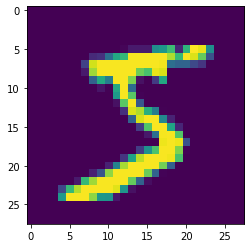

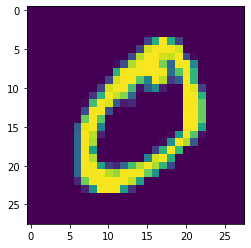

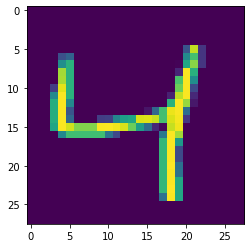

In [9]:
for image in x_train[:3]:
    plt.figure()
    plt.imshow(image)

## Starting Simple: Using the Keras Sequential API

As you will quickly see, there are a ton of ways in TensorFlow to build models and train them. TensorFlow has many APIs that you can use, and all these APIs can be confusing. We start this tutorial with the simplest way to build a model in TensorFlow 2.0: using the Keras Sequential API.

We will first build the tf.keras.Sequential model by stacking layers.   

In [11]:
tf.keras.layers.Dense

(28, 28)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=5)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nTest accuracy:', test_acc)

## More advanced: Writing a custom training loop with Gradient Tape

Now, we transition to a more advanced usage of TensorFlow. This API will probably be the one you will use the most, as it provides for more flexibility. Note that you can specify more unique architectures with the forward pass. We will use the same MNIST dataset.

In [ ]:
# Reload the dataset 
def convert_types(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

dataset, info = tfds.load('mnist', data_dir='gs://tfds-data/datasets', with_info=True, as_supervised=True)
mnist_train, mnist_test = dataset['train'], dataset['test']
mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(32)
mnist_test = mnist_test.map(convert_types).batch(32)

Now, we will go ahead and build the model using tf.keras. Note how building the model this way allows for a greater degree of control over the model.

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

We need to specify an optimizer and loss function, along with metrics:

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Now, we can write our train function:

In [ ]:
@tf.function
def train_step(image, label):
  with tf.GradientTape() as tape:
    predictions = model(image)
    loss = loss_object(label, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(label, predictions)

Note the tf.function annotation on the function above. This means that this function will be compiled into a graph in the backend, allowing it to run efficiently as TensorFlow can optimize the function for you. This automatic conversion of Python code to its graph representation is called AutoGraph, and this creates callable graphs from Python functions.

What is this gradient tape?

In [ ]:
x = tf.Variable(3.0)
with tf.GradientTape() as g:
  y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
print(dy_dx)

Trainable variables are automatically watched within the GradientTape (when trainable=True, as we will see this is not always the case later in the notebook). Variables are trainable when created by tf.Variable, but not when created via tf.constant. In those cases, if you want to compute the gradients of non-trainable variables, you can manually watch the tensors using the watch function, as shown below.

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
print(dy_dx)

Now we can define our test function:

In [ ]:
@tf.function
def test_step(image, label):
  predictions = model(image)
  t_loss = loss_object(label, predictions)

  test_loss(t_loss)
  test_accuracy(label, predictions)

We are ready to train the model!

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
  for image, label in mnist_train:
    train_step(image, label)

  for test_image, test_label in mnist_test:
    test_step(test_image, test_label)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

## Save and Load Models

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [ ]:
# Returns a short sequential model
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model


# Create a basic model instance
model = create_model()
model.summary()

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model = create_model()

model.fit(train_images, train_labels,  epochs = 10,
          validation_data = (test_images,test_labels),
          callbacks = [cp_callback])  # pass callback to training


In [ ]:
model = create_model()

loss, acc = model.evaluate(test_images, test_labels)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

### Saving the entire model

In [ ]:
model = create_model()

model.fit(train_images, train_labels, epochs=5)

# Save entire model to a HDF5 file
model.save('my_model.h5')

In [ ]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## Putting it all Together: Transfer Learning Using Pretrained Models

Here, we will train a model to distinguish between cats and dogs. We will leverage pretrained models for this.

We begin my loading in the dataset, and quickly visualizing it.

In [ ]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

We will preprocess and shuffle the data.

In [ ]:
IMG_SIZE = 128 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Now that we have taken care of our data, we will obtain a pretrained model. For this, we will use the MobileNet model (https://arxiv.org/abs/1801.04381). Note that we are using both its architecture, as well as pretrain weights for the model, trained on imagenet. This architecture will act as a feature extractor for us, and that is why we call it "base_model". We will then feed the features it extracts into more layers.

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

Just to get an idea of this pretrained model, we will pass in a batch of images through it, and examine our output:

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)

Note the input was (16, 128, 128, 3), with batch size as the first dimension. Thus, this feature extractor we have defined converts each 128x128x3 image to a 5x5x128 feature block. Since we only want to use the pretrained model as a feature extractor, we can go ahead and freeze the base. This means that we do not modify the weights of it.

In [ ]:
base_model.trainable = False

Now, we add in the last part of the model, which we will train. First, we will add some average pooling to convert features to a single 1280-element vector per image. After we have that, we will add a single dense layer that outputs the classifications of the images. 

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)